Import the necessary libraries

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import zuko
import numpy as np
import corner as cn

from itertools import islice
from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

Here we define all the functions that will be used in subsequent code blocks to model our waveforms

In [1]:
def phi(time, freq_low, coalescence_time, arrival_time, phase):
    return 16*np.pi*freq_low*coalescence_time*(1-(1-(time-arrival_time)/coalescence_time)**(5/8))/5 + phase

def amplitude(time, chirp_mass, dist, freq_low, arrival_time, coalescence_time):
    return -4*(G*chirp_mass)**(5/3)*(np.pi*freq_low)**(2/3)*(1-(time-arrival_time)/coalescence_time)**(-1/4)/(c**2*dist)

def h_plus(time, chirp_mass, dist, freq_low, arrival_time, coalescence_time, eps, phase):
    return amplitude(time, chirp_mass, dist, freq_low, arrival_time, coalescence_time)*(1+torch.cos(eps)**2)*torch.cos(phi(time, freq_low, coalescence_time, arrival_time, phase))/2

def h_cross(time, chirp_mass, dist, freq_low, arrival_time, coalescence_time, eps, phase):
    return amplitude(time, chirp_mass, dist, freq_low, arrival_time, coalescence_time)*torch.cos(eps)*torch.sin(phi(time, freq_low, coalescence_time, arrival_time, phase))

def f_plus(dec, ra, psi):
    return (1+torch.cos(dec)**2)*torch.cos(2*ra)*torch.cos(2*psi)/2 + torch.cos(dec)*torch.sin(2*ra)*torch.sin(2*psi)

def f_cross(dec, ra, psi):
    return -(1+torch.cos(dec)**2)*torch.cos(2*ra)*torch.sin(2*psi)/2 + torch.cos(dec)*torch.sin(2*ra)*torch.cos(2*psi)

All the parameters that our model uses have been given labels and their bounds defined. The prior is defined using a BoxUniform class from the Zuko package. The parameters are then sampled from this prior.

Next, we construct the waveforms using the functions we defined earlier. The parameters are first unpacked, and then the required number of timepoints are created. The signal data is generated and returned after adding some noise. 

We have used 100 timepoints and 8 variable parameters out of 10. All of this can be edited, including the prior bounds. 

In [4]:
LABELS = ['dec', 'ra', 'psi', 'chirp_mass', 'freq_low', 'arrival_time', 'coalescence_time', 'eps', 'phase', 'dist']
LOWER = torch.tensor([-np.pi/2, -np.pi/2, 0, 30.0, 20.0, 100, 0.0, 0.0, 0.0, 100]).cuda()
UPPER = torch.tensor([np.pi/2, np.pi/2, np.pi, 32.5, 20.0, 100, 2.0, np.pi/2, 2*np.pi, 120]).cuda()

G = 6.67430e-11  # Gravitational constant (m^3/kg/s^2)
c = 299792458.0  # Speed of light (m/s)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)
parameters = prior.sample()

def model(parameters):

    dec =  parameters[...,0]
    ra = parameters[...,1]
    psi = parameters[...,2]
    chirp_mass =  parameters[...,3]
    freq_low = parameters[...,4]
    arrival_time = parameters[...,5]
    coalescence_time = parameters[...,6]
    eps = parameters[...,7]
    phase = parameters[...,8]
    dist = parameters[...,9]

    time = np.linspace(arrival_time.cpu()-8,arrival_time.cpu(),1000)
    time = torch.from_numpy(time).cuda()
    time_indices = torch.randint(0, len(time), (100,))
    time_points = time[time_indices].sort()
    
    x_list = []
    #x = torch.stack([amp*torch.sin(freq*time_points)*torch.exp(-(gauss_param*time_points)**2)], dim=-1)
    for element in time_points[0]:
        x_data= f_plus(dec, ra, psi)*h_plus(element, chirp_mass, dist, freq_low, arrival_time, coalescence_time, eps, phase)+f_cross(dec, ra, psi)*h_cross(element, chirp_mass, dist, freq_low, arrival_time, coalescence_time, eps, phase)
        x_list.append(x_data)
    x = torch.stack(x_list, dim=-1)
    
    '''for i in range(5):
        x=torch.zeros(5)
        x[i] =torch.stack([amp*torch.sin(freq*time_points[i])*torch.exp(-(gauss_param*time_points[i])**2)], dim =-1)'''

    return x + 0.05*torch.randn_like(x)

In [5]:
data = model(parameters).cuda()
print(data)

tensor([-0.0848, -0.0597, -0.0014, -0.0068,  0.0278, -0.1088, -0.0286,  0.0037,
         0.0541,  0.0047,  0.0225,  0.0172, -0.0030, -0.0023, -0.0262, -0.0283,
         0.0004,  0.0326, -0.0586,  0.0175, -0.0739,  0.0235, -0.0054,  0.0779,
        -0.0304,  0.0298,  0.0333,  0.0171,  0.0025, -0.0683, -0.0123,  0.0328,
        -0.0138, -0.0526,  0.0091,  0.0721,  0.0164, -0.0962, -0.0242,  0.0031,
        -0.0454,  0.0347,  0.0296,  0.0075,  0.0522,  0.0455, -0.0351,  0.0617,
         0.0293, -0.0307,  0.0214, -0.0231, -0.0646, -0.0675,  0.0301,  0.0182,
         0.0134, -0.0938,  0.0067, -0.1775,  0.0277,  0.0088,  0.0263,  0.0561,
        -0.0172,  0.0599,  0.0282,  0.0070, -0.0521, -0.0047,  0.0245,  0.0160,
         0.0138, -0.0365, -0.0845, -0.0804,  0.0733,  0.0419,  0.0340, -0.0236,
        -0.0820, -0.0646, -0.0066, -0.0044,  0.0248,  0.0165, -0.0030, -0.0124,
         0.0188,  0.0328, -0.0143, -0.0313, -0.0595, -0.0362,  0.0443, -0.0087,
        -0.0815,  0.0171, -0.0426,  0.05

The data that we generated needs to be arranged, or "loaded" in a specific way to easily calculate the minimize the loss function. To this end, we use the JointLoader class provided by the Lampe package. The JointLoader class generated batched pairs of the parameters and subsequent data points. In our case, it wrings out 256 batches. 

We then proceed to instantiate the normalizing flow, which is an NPE class offered by Lampe. It takes in the number of parameters(or dimensionality of the parameter space) and number of datapoints(or dimesnionality of the observation space) as its first and second input respectively. We can also specify the number of transforms and hidden layer features that the neural network should posses. Care must be taken in this step. If you have changed the number of parameters in the model, or have used a different model, or have changed the number of datapoints that the model simulates, then that change must be reflected in the estimator by correctly specifying their new values.

Finally, the loss function is defined, the NPELoss class from Lampe. It is the negative log likelihood of the neural density estimator(i.e. the NPE class). 

In [6]:
loader = JointLoader(prior, model, batch_size=256, vectorized=True)
estimator = NPE(10, 100, transforms=3, hidden_features=[64] * 3)
loss = NPELoss(estimator).cuda()

In [7]:
print(estimator)

NPE(
  (flow): MAF(
    (transform): LazyComposedTransform(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=110, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): MaskedLinear(in_features=64, out_features=20, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=110, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features

For the Gradient Descent step, and Adam optimizer is used aling with a clip of 1. The estimator is set into train mode, and the training begins. The loss function is calculated for each batch that the JointLoader produced earlier, and is later minimized. We trained the network over 64 epochs.

In [8]:
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(64, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 64/64 [1:11:35<00:00, 67.11s/epoch, loss=11]  


Once the network has been trained, it may be saved using an appropriate file path, that can enable you to identify which model you used to train it. This can prevent any unnecessary confusion if you want to train the network for different combinations but don't want to lose the training progress.

In [164]:
# Specify a path
PATH = "entire_model_100_3_6.pt"

# Save
torch.save(estimator, PATH)

# Load
estimator = torch.load(PATH)


Finally, we perform parameter estimation on a waveform that the model has not encountered before to see how it fares against new data. The results have been shown in later sections in the form of corner plots using Lampe's own corner class, as well as Python's inbuilt corner module

In [9]:
theta_star = prior.sample()
x_star = model(theta_star)

estimator.eval()

with torch.no_grad():
    samples = estimator.flow(x_star.float()).sample((2**16,))

In [10]:
print(theta_star)

tensor([ -1.1258,  -1.5665,   0.7423,  31.7028,  20.0000, 100.0000,   0.5184,
          1.1834,   3.5948, 104.4686], device='cuda:0')


In [136]:
print(samples[:,3].shape)

torch.Size([65536])


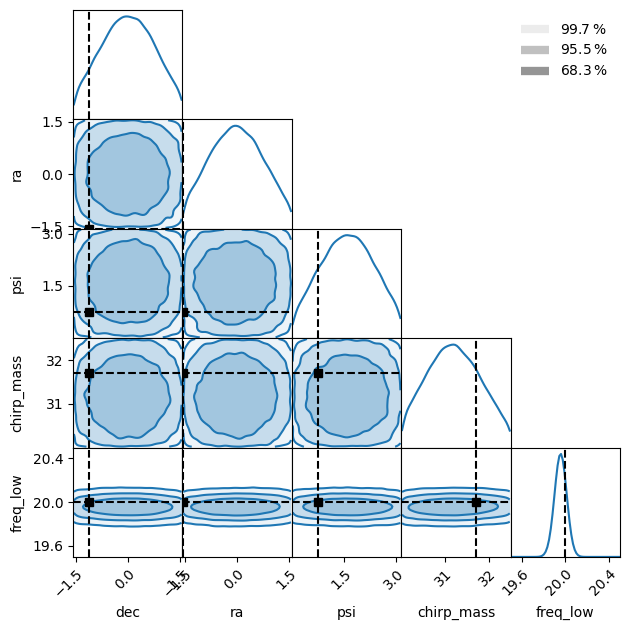

In [11]:
fig = corner(
    samples[:,0:5].cpu(),
    smooth=2,
    domain=(LOWER[0:5].cpu(), UPPER[0:5].cpu()),
    labels=LABELS[0:5],
    #legend=r'\$p_phi(theta | x^*)\$',
    #figsize=(4.8, 4.8),
)

mark_point(fig, theta_star[0:5].cpu())

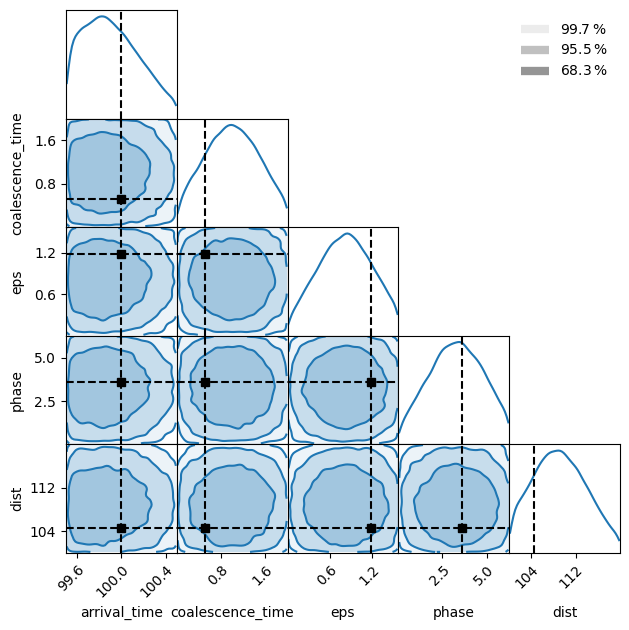

In [12]:
fig = corner(
    samples[:,5:].cpu(),
    smooth=2,
    domain=(LOWER[5:].cpu(), UPPER[5:].cpu()),
    labels=LABELS[5:],
    #legend=r'\$p_phi(theta | x^*)\$',
    #figsize=(4.8, 4.8),
)

mark_point(fig, theta_star[5:].cpu())

In [13]:
val= samples.mean()
print(val)

tensor(26.5978, device='cuda:0')


In [14]:
print(samples[:,9].mean())

tensor(108.4823, device='cuda:0')


In [15]:
print(losses)

[tensor(9.6376, device='cuda:0'), tensor(9.4521, device='cuda:0'), tensor(9.5890, device='cuda:0'), tensor(9.4307, device='cuda:0'), tensor(9.5190, device='cuda:0'), tensor(9.5052, device='cuda:0'), tensor(9.5849, device='cuda:0'), tensor(9.3633, device='cuda:0'), tensor(9.4885, device='cuda:0'), tensor(9.3618, device='cuda:0'), tensor(9.6781, device='cuda:0'), tensor(9.5026, device='cuda:0'), tensor(9.5699, device='cuda:0'), tensor(9.5816, device='cuda:0'), tensor(9.3562, device='cuda:0'), tensor(9.5471, device='cuda:0'), tensor(9.7070, device='cuda:0'), tensor(9.5944, device='cuda:0'), tensor(9.2796, device='cuda:0'), tensor(9.4194, device='cuda:0'), tensor(9.7819, device='cuda:0'), tensor(9.5357, device='cuda:0'), tensor(9.3229, device='cuda:0'), tensor(9.2211, device='cuda:0'), tensor(9.7497, device='cuda:0'), tensor(9.6724, device='cuda:0'), tensor(9.4112, device='cuda:0'), tensor(9.3514, device='cuda:0'), tensor(9.8036, device='cuda:0'), tensor(9.6484, device='cuda:0'), tensor(9.

This plot shows how the loss behaves with each successfull iteration over the 256 batches

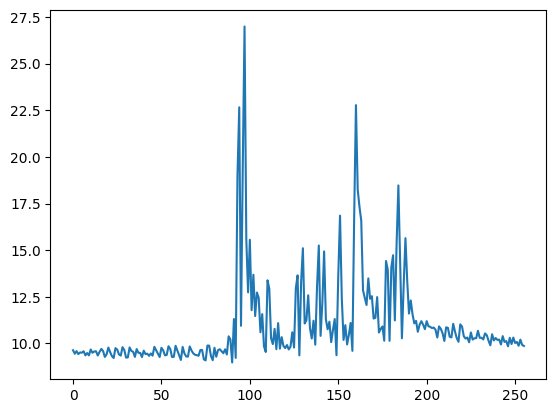

In [16]:
losses_numpy = [tensor.cpu().numpy() for tensor in losses]

plt.plot(losses_numpy)
plt.show()

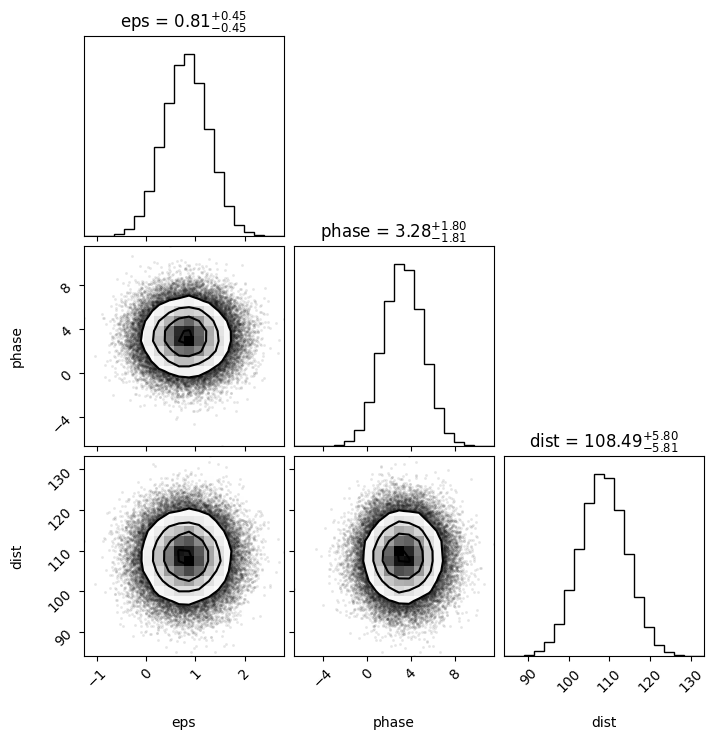

In [17]:
fig = cn.corner(samples[:,7:10].cpu().numpy(), bins=20, labels=LABELS[7:10], show_titles=True)

In [186]:
print(samples[:,0:1].cpu().numpy())

[[ 0.9204104 ]
 [-0.40286162]
 [ 1.3208662 ]
 ...
 [ 0.25408998]
 [ 1.0826166 ]
 [ 0.15769823]]


In [187]:
samples_numpy = samples.cpu().numpy()

In [195]:
print(samples_numpy[:,:4])

[[ 0.9204104  -0.12018167  3.103394   30.868225  ]
 [-0.40286162  0.5170603   2.465238   30.091866  ]
 [ 1.3208662   1.8281026   1.9395587  31.555275  ]
 ...
 [ 0.25408998  1.7893605   3.079088   31.543682  ]
 [ 1.0826166  -0.4088347   1.7458354  30.912468  ]
 [ 0.15769823  1.6197737   2.5207243  31.432163  ]]


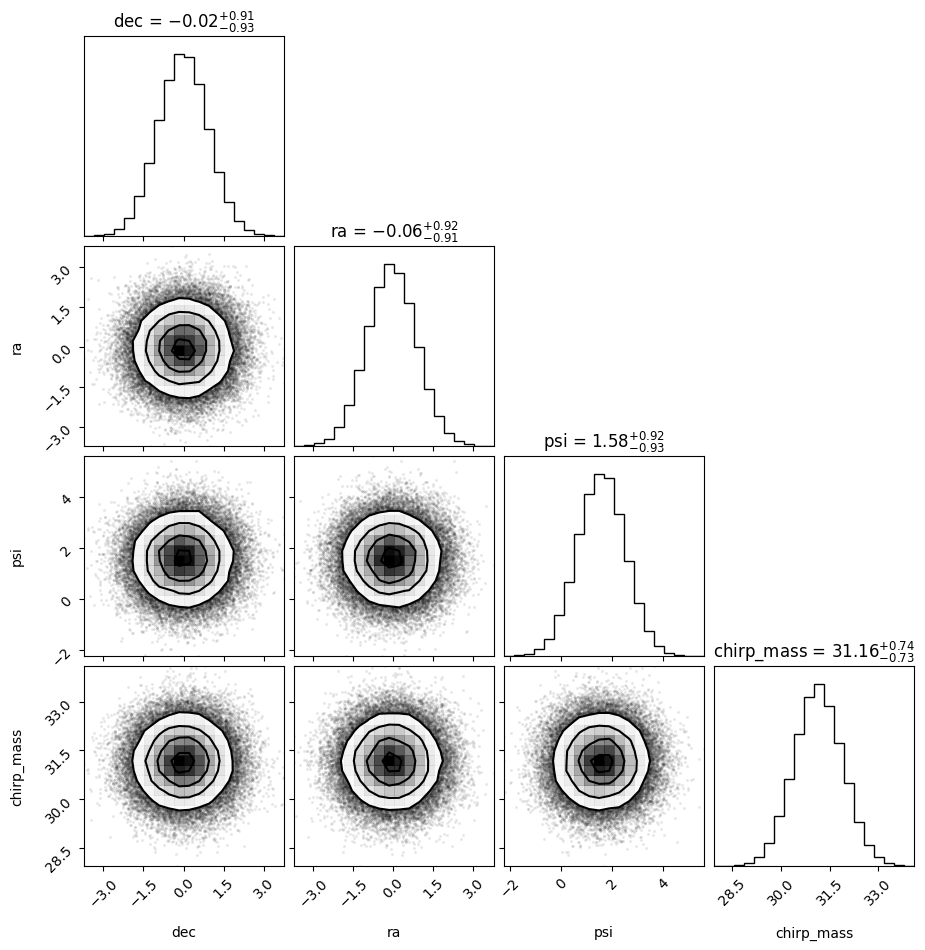

In [18]:
fig1 = cn.corner(samples[:,0:4].cpu().numpy(), bins=20, labels=LABELS[0:4], show_titles=True)

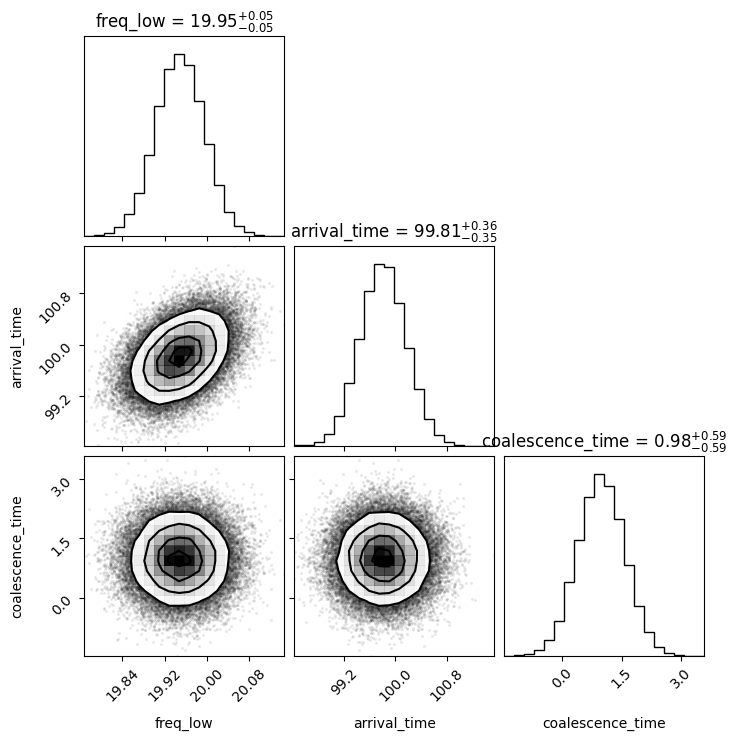

In [19]:
fig2 = cn.corner(samples[:,4:7].cpu().numpy(), bins=20, labels=LABELS[4:7], show_titles=True)